# **Speech Emotion Recognition (Classification) in real-time using Deep LSTM layers**
### ***A Deep Learning LSTM based model with keras.***




# **ABSTRACT**
 
This classification model is developed in a Deep Learning method, meaning a Deep Neural Network (DNN) while an advanced model for time-series analysis has been chosen, which is the Long Short-Term Memory (LSTM). 

For the train of the model, expressed emotions by actors have been used from The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) from the Ryerson University, as well as the Toronto Emotional Speech Set (TESS) from the University of Toronto.

---



# **LIBRARIES**

In [18]:
%%capture
!pip install pydub noisereduce json-tricks

In [1]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

# **THE DATA**
The speech emotion audio databases used:

- **The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. 
  - **1440 files** = 24 actors x 60 trails per actor
  - **8 Emotions** (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

- **Toronto Emotional Speech Set (TESS)**
https://tspace.library.utoronto.ca/handle/1807/24487
  - These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions described below.
Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.
  - **2800 files** = 2 actors x 200 pharses x 7 emotions
  - **7 Emotions** (neutral, happiness, sadness, anger, fear, disgust, pleasant surprise)
   - ('calm' is not a part of this DB)


## **Initial extractions**
The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a fixed placed int that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a string representation of an emotion, e.g 'happy'.


2**The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`. 
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Trimming the silence in the beginning and the end by `librosa`.
*   Padding every audio file to the maximum length by `numpy`, for length equalization.
*   Noise reduction is being performed by `noisereduce`.
---



## **Features extraction**
The selected features being extracted with `librosa` for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 


Audio preprocess and feature extraction is presented for a single audio file in "preprocessing__audiofile" notebook.

In [2]:

def find_emotion_type(name):
    if 'neutral' in name:
        return "01"
    elif 'happy' in name:
        return "03"
    elif 'sad' in name:
        return "04"
    elif 'angry' in name:
        return "05"
    elif 'fear' in name:
        return "06"
    elif 'disgust' in name:
        return "07"
    elif 'ps' in name:
        return "08"
    else:
        return "-1"


def fix_emotion(e_num):
    if e_num == "01":
        return 0  # neutral
    elif e_num == "02":
        return 1  # calm
    elif e_num == "03":
        return 2  # happy
    elif e_num == "04":
        return 3  # sad
    elif e_num == "05":
        return 4  # angry
    elif e_num == "06":
        return 5  # fear
    elif e_num == "07":
        return 6  # disgust
    else:
        return 7  # surprised

In [3]:
sample_lengths = []
folder_path = 'data\\SER-en'

for subdir, dirs, files in os.walk(folder_path):

    for file in files:
        x, sr = librosa.load(path=os.path.join(subdir, file), sr=None)
        xt, index = librosa.effects.trim(x, top_db=30)

        sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


## **THE PREPROCESS**
Following the preprocessing presentation for a single audio file in "preprocessing_audiofile" notebook, the full data will be preprocessed and extracted as the speech features chosen.

In [22]:
import time

tic = time.perf_counter()

rms = []
zcr = []
mfcc = []
emotions = []

total_length = 373056
frame_length = 2048
hop_length = 512

folder_path = 'data\\SER-en'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:

        _, sr = librosa.load(path=os.path.join(subdir, file),
                             sr=None)
        raw_sound = AudioSegment.from_file(os.path.join(subdir, file))
        normalized_sound = effects.normalize(raw_sound, headroom=0)
        normal_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')
        xt, index = librosa.effects.trim(normal_x, top_db=30)
        padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
        final_x = nr.reduce_noise(padded_x, sr=sr)
        f1 = librosa.feature.rms(y=final_x, frame_length=frame_length,
                                 hop_length=hop_length)  # Energy - Root Mean Square   
        f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,
                                                center=True)  # ZCR      
        f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCC

        if find_emotion_type(file) != "-1":  #TESS database validation
            name = find_emotion_type(file)
        else:  #RAVDESS database validation
            name = file[6:8]

        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(fix_emotion(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic) / 60:0.4f} minutes")

data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-01-01-01-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-01-01-01-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-01-01-02-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-01-01-02-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-01-01-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-01-01-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-01-02-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-01-02-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-02-01-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-02-01-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-02-02-01-01.wav
data\SER-en\Ravdess\audio_speech_actors_01-24\Actor_01 03-01-02-02-02-02-01.wav
data\SER-en\Ravdess\audio_speech_actors_

# **DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format: 

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape (keras library requirement)
*   Split of X, Y to train, validation, and test sets.
*   y_train and y_validation conversion to 'One-hot' vectors for classification purposes (y_test is being converted adjacent to the test)




**X, Y Setup**

In [23]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms, 1, 2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr, 1, 2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs, 1, 2)

print('ZCR shape:', f_zcr.shape)
print('RMS shape:', f_rms.shape)
print('MFCCs shape:', f_mfccs.shape)

ZCR shape: (4238, 729, 1)
RMS shape: (4238, 729, 1)
MFCCs shape: (4238, 729, 13)


In [24]:
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

**Save & Load X,Y to JSON files**

In [25]:
x_data = X.tolist()
x_path = 'output/X_datanew.json'
dump(obj=x_data, fp=x_path)

y_data = Y.tolist()
y_path = 'output/Y_datanew.json'
dump(obj=y_data, fp=y_path)


'[[0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2]

In [26]:
x_path = 'output/X_datanew.json'
X = load(x_path)
X = np.asarray(X, dtype='float32')

y_path = 'output/Y_datanew.json'
Y = load(y_path)
Y = np.asarray(Y, dtype='int8')


*   **Split X, Y To Train, Validation, and Test Sets**
*   **y_train and y_val conversion to One-Hot vectors.**



In [54]:
from sklearn.model_selection import train_test_split

x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size=0.125, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size=0.304, random_state=1)

y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8)

In [28]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3708, 729, 15)
(368, 729, 15)
(162, 729, 15)


In [29]:

file_path = 'output/x_test_data.json'
dump(obj=x_test, fp=file_path)

file_path = 'output/y_test_data.json'
dump(obj=y_test, fp=file_path)

'{"__ndarray__": [[5], [5], [6], [3], [4], [0], [2], [3], [6], [0], [7], [4], [4], [6], [4], [0], [2], [6], [5], [6], [3], [3], [3], [2], [4], [0], [2], [7], [4], [6], [4], [0], [3], [4], [7], [3], [6], [0], [2], [3], [2], [5], [4], [7], [2], [3], [3], [0], [4], [7], [2], [4], [2], [7], [5], [4], [6], [6], [5], [6], [7], [4], [2], [6], [0], [3], [0], [2], [6], [4], [6], [0], [2], [6], [6], [6], [2], [2], [4], [7], [4], [3], [7], [6], [6], [1], [5], [1], [7], [4], [4], [6], [3], [6], [3], [4], [0], [4], [3], [5], [2], [7], [2], [4], [3], [4], [2], [3], [0], [6], [6], [1], [0], [3], [5], [4], [3], [7], [5], [4], [3], [3], [4], [1], [5], [0], [0], [5], [2], [7], [7], [0], [0], [5], [3], [7], [2], [5], [6], [4], [3], [5], [2], [3], [7], [1], [2], [3], [6], [3], [6], [3], [2], [5], [2], [6], [0], [5], [0], [7], [5], [1]], "dtype": "int8", "shape": [162, 1], "Corder": true}'

# **MODEL DEFINITION & TRAIN**
The model is executed with keras library, using 2 hidden LSTM layers with 64 nodes, and an output (dense) layer with 8 nodes, each for one emotion using the 'softmax' activation.
The optimizer that led to the best results was 'RMSProp' with default parameters.


In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64))
model.add(Dense(8, activation='softmax'))
print(model.summary())

batch_size = 23

checkpoint_path = 'output/best_weights.keras'

mcp_save = ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
rlrop = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                          factor=0.1, patience=100)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                    epochs=340, batch_size=batch_size,
                    validation_data=(x_val, y_val_class),
                    callbacks=[mcp_save, rlrop])

model.load_weights(checkpoint_path)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 729, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 59s 354ms/step - categorical_accuracy: 0.1766 - loss: 2.0101 - val_categorical_accuracy: 0.2908 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 2/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 54s 336ms/step - categorical_accuracy: 0.2612 - loss: 1.8149 - val_categorical_accuracy: 0.3016 - val_loss: 1.7309 - learning_rate: 0.0010
Epoch 3/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 55s 339ms/step - categorical_accuracy: 0.3052 - loss: 1.7386 - val_categorical_accuracy: 0.2745 - val_loss: 1.7208 - learning_rate: 0.0010
Epoch 4/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 256ms/step - categorical_accuracy: 0.3122 - loss: 1.7165 - val_categorical_accuracy: 0.1929 - val_loss: 2.2203 - learning_rate: 0.0010
Epoch 5/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - categorical_accuracy: 0.3287 - loss: 1.7217 - val_categorical_accuracy: 0.3071 - val_loss: 1.7575 - learning_rate: 0.0010
Epoch 6/340
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - categorical_accuracy: 0.3477 - loss: 

# **MODEL EVALUATION**
The model has been evaluated using the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## **Train (fit) Visualization**

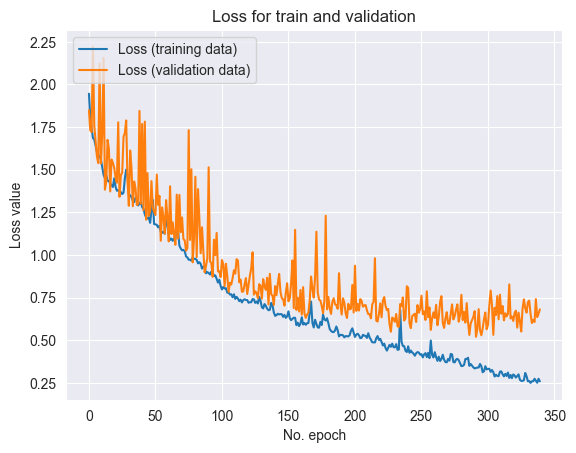

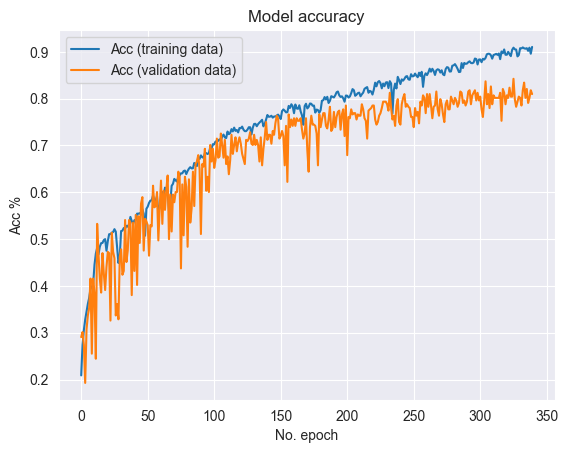

In [33]:

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [34]:
loss, acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 2s - 171ms/step - categorical_accuracy: 0.8424 - loss: 0.5515


**Val Set Confussion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

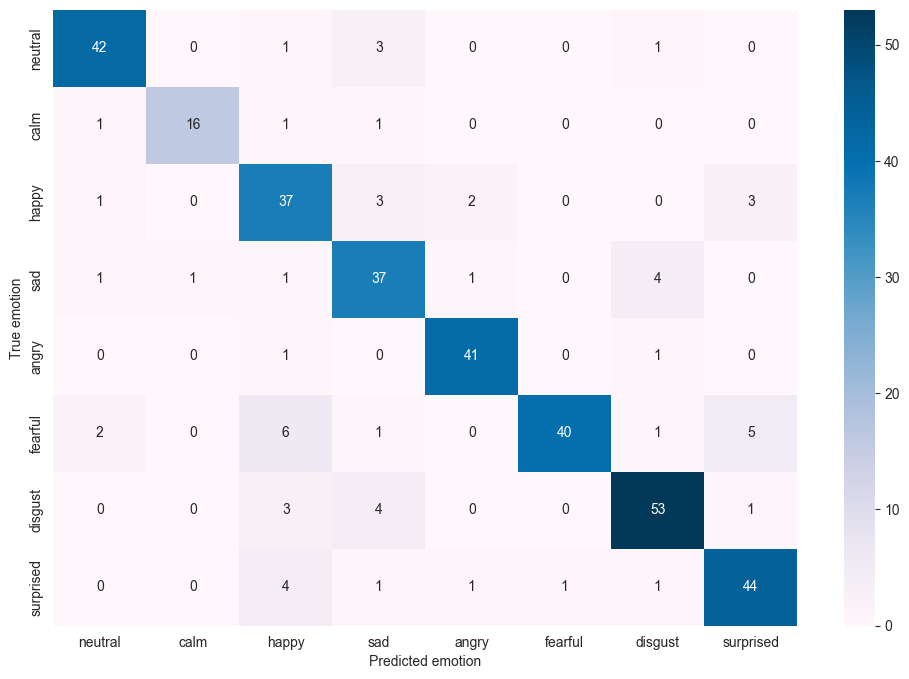

In [55]:
import pandas as pd

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(12, 8))
ax = plt.axes()

sns.heatmap(cm_df, ax=ax, cmap='PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Validation Set Predicted emotions accuracy**

In [41]:
values = cm.diagonal()
row_sum = np.sum(cm, axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e], ':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.8936
calm : 0.8421
happy : 0.8043
sad : 0.8222
angry : 0.9535
fearful : 0.7273
disgust : 0.8689
surprised : 0.8462


## **Save & Load model, weights**


In [44]:
model_json = model.to_json()
saved_model_path = 'output/model.json'
saved_weights_path = 'output/model.weights.h5'

with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [47]:
saved_model_path = 'output/model.json'
saved_weights_path = 'output/model.weights.h5'

with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['categorical_accuracy'])

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [49]:
x_test = load('output/x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('output/y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, num_classes=8)

## **Test Set Evaluation**

**Test Set Score**

In [50]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 2s - 379ms/step - categorical_accuracy: 0.8333 - loss: 0.4368


**Test Set Confussion Matrix**

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

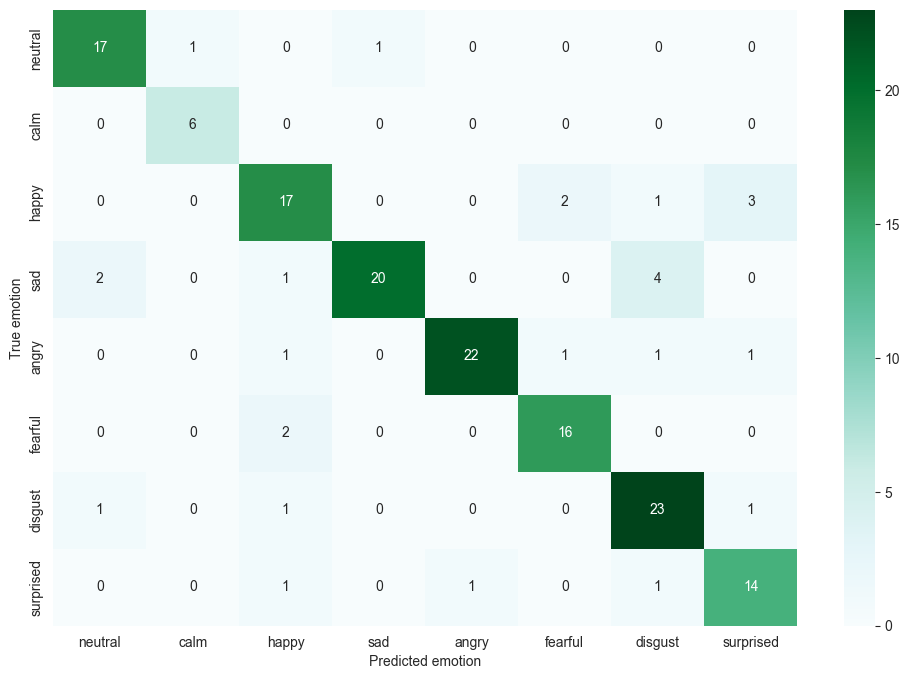

In [51]:
y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(12, 8))
ax = plt.axes()

sns.heatmap(cm_df, ax=ax, cmap='BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [52]:
values = cm.diagonal()
row_sum = np.sum(cm, axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e], ':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8947
calm : 1.0000
happy : 0.7391
sad : 0.7407
angry : 0.8462
fearful : 0.8889
disgust : 0.8846
surprised : 0.8235
